#Reading datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/Shared drives')
os.chdir('RL Final Project')

Mounted at /content/drive


# EDA

In [ ]:
import pandas as pd
df = pd.read_csv('journeys.csv')
journeys = df
journeys.head()

,Trip ID Hash,Car ID Hash,Car Parking Address Postcode,Car Parking Address City,Trip Start At Local Time,Trip End At Local Time,Trip Created At Local Time,Trip Sum Trip Price
0,00010247034d28272cf5e1e16b43f52f,9ddac6a5fb0b3962db3b2f42fd31d3f9,94110,San Francisco,2017-11-14 22:15:00,2017-11-15 02:15:00,2017-11-14 20:32:59,$20.00
1,0001556e5d28e66b3318e89c094186c4,0f386ec90e0710ca143922520eaf8a3e,94117,San Francisco,2017-12-07 17:00:00,2017-12-08 04:00:00,2017-12-07 04:51:42,$55.00
2,000286e8771651e6983555c62558b57f,63e4509c686d891f5364c24339369460,94115,San Francisco,2017-03-23 10:00:00,2017-03-23 12:00:00,2017-03-23 08:49:48,$18.00
3,0003651ffd2f07a7226fd6b7c979fecb,c9fbe5bf8e406cd13bd33ff5411fa3e3,94103,San Francisco,2017-07-05 19:00:00,2017-07-06 01:45:00,2017-07-05 01:07:31,$33.75
4,000416e4334896da4a366e17ce42152e,48275fb73951c77021f9d820d15c5139,2118,Boston,2017-01-24 09:00:00,2017-01-24 11:30:00,2017-01-22 22:47:11,$21.25


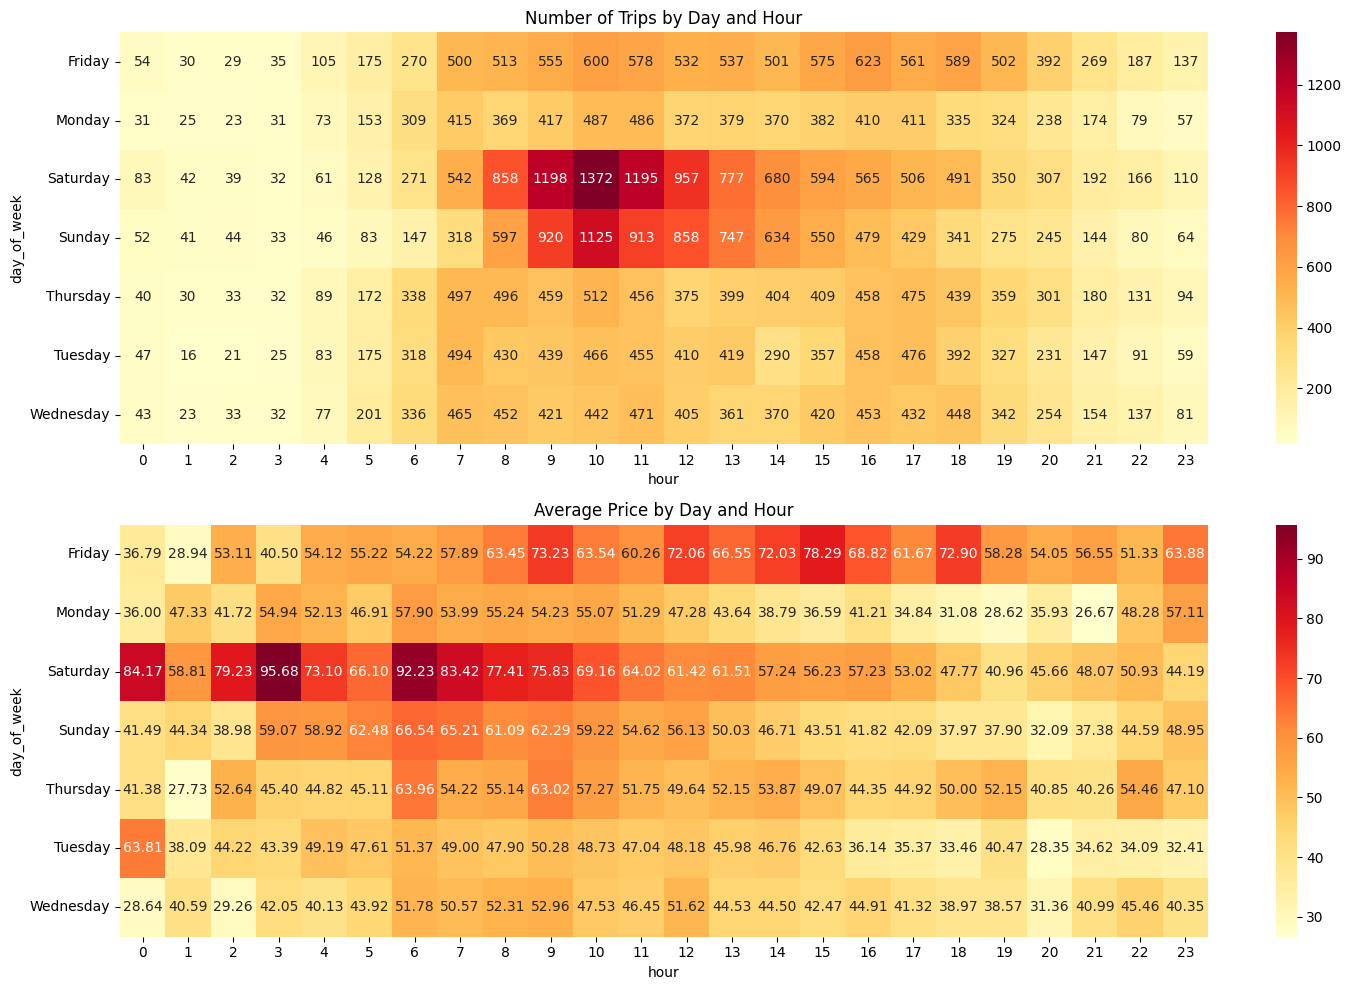


Hourly Statistics:
     Trip Sum Trip Price              Duration (Hour)
                    mean    std count            mean
hour                                                 
0                  51.80  87.14   350           11.21
1                  42.10  62.32   207            8.91
2                  49.26  66.97   222            9.71
3                  54.61  66.36   220           11.08
4                  52.10  38.09   534           10.32
5                  50.97  45.88  1087            9.77
6                  61.67  68.77  1989           12.81
7                  59.42  50.46  3231           11.24
8                  61.21  55.35  3715           11.17
9                  64.57  59.77  4409           11.57
10                 59.85  56.21  5004           10.47
11                 55.56  51.67  4554            9.35
12                 56.83  67.43  3909            9.79
13                 53.49  55.20  3619            9.21
14                 52.56  59.68  3249            9.53
15      

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate duration first
journeys['Trip Start At Local Time'] = pd.to_datetime(journeys['Trip Start At Local Time'])
journeys['Trip End At Local Time'] = pd.to_datetime(journeys['Trip End At Local Time'])
journeys['Duration (Hour)'] = (journeys['Trip End At Local Time'] - journeys['Trip Start At Local Time']).dt.total_seconds() / 3600

# Extract time features
journeys['day_of_week'] = journeys['Trip Start At Local Time'].dt.day_name()
journeys['hour'] = journeys['Trip Start At Local Time'].dt.hour

# Trip Sum Trip Price preprocessing - remove $ and comma
journeys['Trip Sum Trip Price'] = journeys['Trip Sum Trip Price'].str.replace('$', '').str.replace(',', '').astype(float)

# Time pattern analysis
time_patterns = journeys.groupby(['day_of_week', 'hour']).agg({
   'Trip ID Hash': 'count',
   'Trip Sum Trip Price': 'mean',
   'Duration (Hour)': 'mean'
}).reset_index()

# Visualization
plt.figure(figsize=(15, 10))

# 1. Number of trips by day/hour
plt.subplot(2,1,1)
pivot_data = time_patterns.pivot(index='day_of_week', columns='hour', values='Trip ID Hash')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Number of Trips by Day and Hour')

# 2. Average price by day/hour
plt.subplot(2,1,2)
pivot_price = time_patterns.pivot(index='day_of_week', columns='hour', values='Trip Sum Trip Price')
sns.heatmap(pivot_price, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Average Price by Day and Hour')

plt.tight_layout()
plt.show()

# Detailed statistics
print("\nHourly Statistics:")
hourly_stats = journeys.groupby('hour').agg({
   'Trip Sum Trip Price': ['mean', 'std', 'count'],
   'Duration (Hour)': 'mean'
}).round(2)
print(hourly_stats)

# Identify most profitable hours
profitable_hours = hourly_stats['Trip Sum Trip Price']['mean'].sort_values(ascending=False).head()
print("\nMost Profitable Hours:")
print(profitable_hours)

#Trips Pattern:</br>
Peak demand time: Saturday and Sunday 9-11AM (800-1300+ items)</br>
Weekday peak: 7-11AM, 4-6PM</br>
Minimum demand: 1-4AM (all days)</br>

#Price Pattern:</br>
Highest price range: </br>

Saturday 3AM ($95.68) </br>

Saturday 12AM ($84.17)</br>

Saturday 6AM ($92.23)</br>

#Weekday prices:</br>
High overall price range on Friday</br>
Mid-day (7-11AM) on weekdays</br>
Relatively low price range in the evening</br>

# Finding the Probability Distribution


#### Acquire all the hourly rate from trips available and take the ratio of their frequency to the sum of all trips as its probability. Fit the distribution with Gaussian Distribution (Normal Distribution) to get the probability distribution correlation in our case.
(Similar to true_probs = [0.9, 0.8, 0.7, 0.6, 0.5])

Fitted Gaussian Parameters: a=0.1618, mu=6.5152, sigma=2.4761


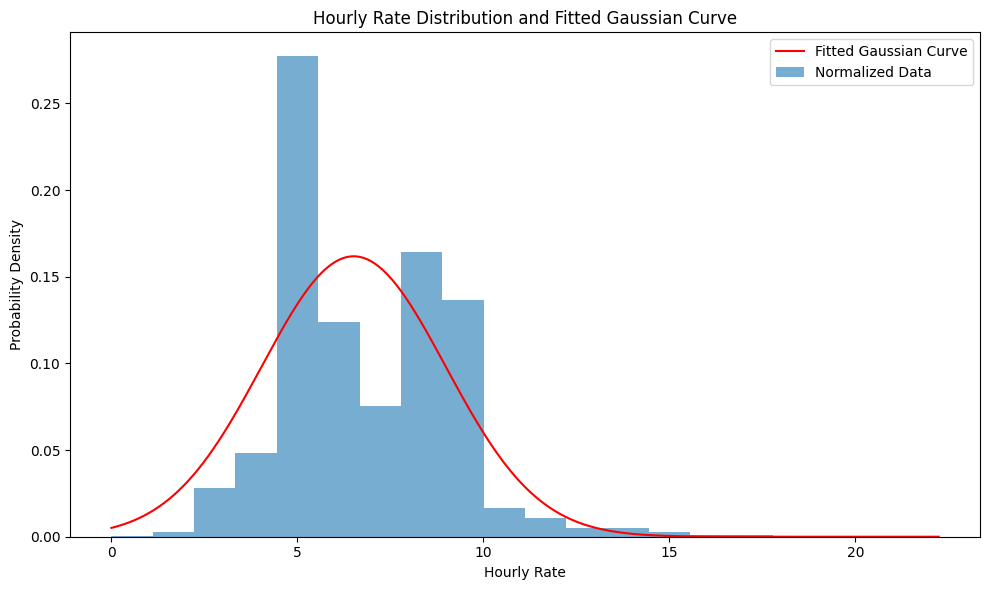

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad

df = pd.read_csv('journeys.csv')

# Work out the hourly rate based on the dataset
df['Trip Start At Local Time'] = pd.to_datetime(df['Trip Start At Local Time'])
df['Trip End At Local Time'] = pd.to_datetime(df['Trip End At Local Time'])
df['Duration (Hour)'] = (df['Trip End At Local Time'] - df['Trip Start At Local Time']).dt.total_seconds() / 3600
df['Trip Price'] = df['Trip Sum Trip Price'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Hourly Rate'] = df['Trip Price'] / df['Duration (Hour)']

# Define a Gaussian function
def gaussian(x, a, mu, sigma):
    """Gaussian function for curve fitting.
    Args:
        x: The input variable.
        a: Amplitude of the Gaussian.
        mu: Mean of the Gaussian.
        sigma: Standard deviation of the Gaussian.
    Returns:
        Gaussian function value for input x.
    """
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Extract the 'Hourly Rate' column from the DataFrame
hourly_rates = df['Hourly Rate'].values

# Create a histogram of the data
counts, bin_edges = np.histogram(hourly_rates, bins=20, density=True)  # Generate a normalized histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for visualization

# Remove invalid or zero-frequency bins
valid_indices = counts > 0  # Only keep bins with positive frequency
bin_centers = bin_centers[valid_indices]
counts = counts[valid_indices]

# Set initial guesses for the Gaussian parameters
p0 = [np.max(counts), bin_centers[np.argmax(counts)], np.std(hourly_rates)]  # [amplitude, mean, std deviation]

# Fit the Gaussian curve to the histogram data
try:
    # Fit the Gaussian function using curve_fit
    params, _ = curve_fit(gaussian, bin_centers, counts, p0=p0, maxfev=5000)

    # Normalize the Gaussian to ensure its total area under the curve equals 1
    normalization_factor = quad(lambda x: gaussian(x, *params), bin_edges[0], bin_edges[-1])[0]  # Compute total area
    params[0] /= normalization_factor  # Adjust amplitude (a) for normalization

    # Print the fitted Gaussian parameters
    print(f"Fitted Gaussian Parameters: a={params[0]:.4f}, mu={params[1]:.4f}, sigma={params[2]:.4f}")

    x_plot = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    y_plot = gaussian(x_plot, *params)
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], alpha=0.6, label='Normalized Data')
    plt.plot(x_plot, y_plot, label='Fitted Gaussian Curve', color='red')
    plt.title('Hourly Rate Distribution and Fitted Gaussian Curve')
    plt.xlabel('Hourly Rate')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

except RuntimeError as e:
    print(f"Could not fit data: {e}")

## Use the fitted gaussian to generate the utilization rate distribution and run simulation over it.

Thompson Sampling Results:
Selection Counts: [  32.   32.   33.   33.   69.   44.   93.   87.   78.   80.  328.  276.
 1356.  160.  423.  260.  274.  381.  169.   54.   33.   55.   54.   45.
   45.   33.   46.   33.   31.   32.   32.   34.   33.   33.   34.   32.
   32.   33.   32.   36.]
Cumulative Rewards: 564
Epsilon-Greedy Results:
Selection Counts: [  65.   37.   43.   32.   31.   36.   46.   41.   31.  165.   47.   44.
 3276.   44.   57.   33.   38.  104.   43.   35.   33.   40.   41.   39.
   39.   42.   43.   33.   28.   38.   40.   38.   40.   28.   36.   32.
   49.   47.   33.   33.]
Cumulative Rewards: 642


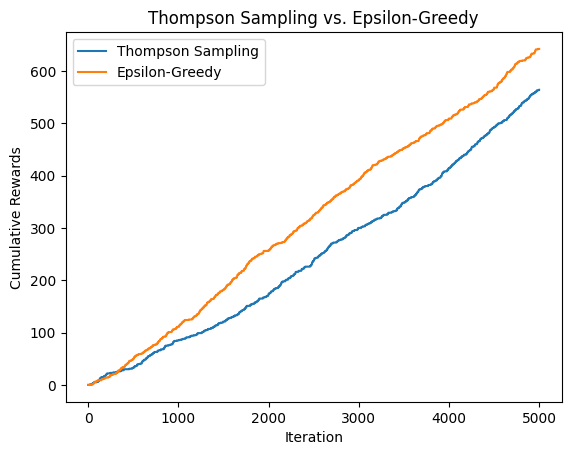

In [ ]:
# Simulation parameters
prices = np.arange(0, 20, 0.5)
true_utilization_rates = [gaussian(i, params[0], params[1], params[2]) for i in prices]  # True success

num_prices = len(true_utilization_rates)
num_iterations = 5000
epsilon = 0.3  # Exploration probability for Epsilon-Greedy

# Initialize variables for Thompson Sampling
successes = np.zeros(num_prices)
failures = np.zeros(num_prices)
th_rewards = []
th_selection_counts = np.zeros(num_prices)

# Initialize variables for Epsilon-Greedy
q_values = np.zeros(num_prices)
counts = np.zeros(num_prices)
eps_rewards = []
eps_selection_counts = np.zeros(num_prices)

for _ in range(num_iterations):
    # --- Thompson Sampling ---
    th_samples = [np.random.beta(successes[i] + 1, failures[i] + 1) for i in range(num_prices)]
    th_price_idx = np.argmax(th_samples)
    th_reward = 1 if np.random.rand() < true_utilization_rates[th_price_idx] else 0
    th_rewards.append(th_reward)
    th_selection_counts[th_price_idx] += 1
    if th_reward:
        successes[th_price_idx] += 1
    else:
        failures[th_price_idx] += 1

    # --- Epsilon-Greedy ---
    if np.random.rand() < epsilon:
        eps_price_idx = np.random.randint(num_prices)  # Explore
    else:
        eps_price_idx = np.argmax(q_values)  # Exploit
    eps_reward = 1 if np.random.rand() < true_utilization_rates[eps_price_idx] else 0
    eps_rewards.append(eps_reward)
    eps_selection_counts[eps_price_idx] += 1
    counts[eps_price_idx] += 1
    alpha = 1 / counts[eps_price_idx]  # Learning rate
    q_values[eps_price_idx] += alpha * (eps_reward - q_values[eps_price_idx])

print("Thompson Sampling Results:")
print(f"Selection Counts: {th_selection_counts}")
print(f"Cumulative Rewards: {np.sum(th_rewards)}")

print("Epsilon-Greedy Results:")
print(f"Selection Counts: {eps_selection_counts}")
print(f"Cumulative Rewards: {np.sum(eps_rewards)}")

plt.plot(np.cumsum(th_rewards), label="Thompson Sampling")
plt.plot(np.cumsum(eps_rewards), label="Epsilon-Greedy")
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.legend()
plt.title("Thompson Sampling vs. Epsilon-Greedy")
plt.show()

## Plot recommended price range by the two methods.

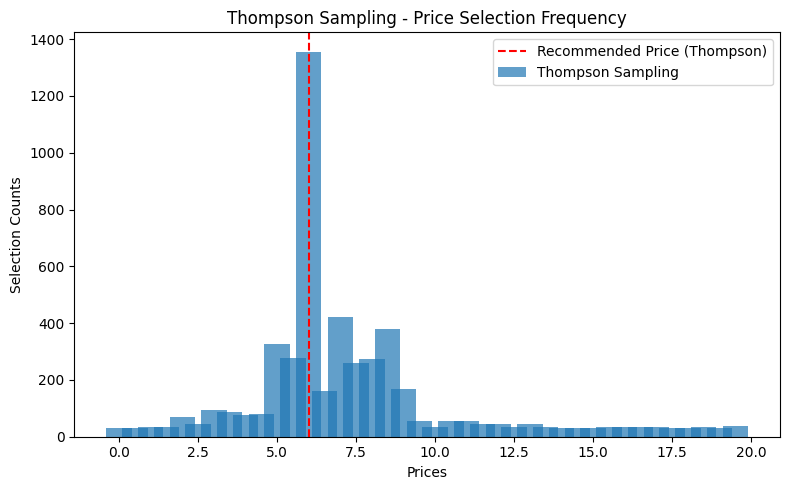

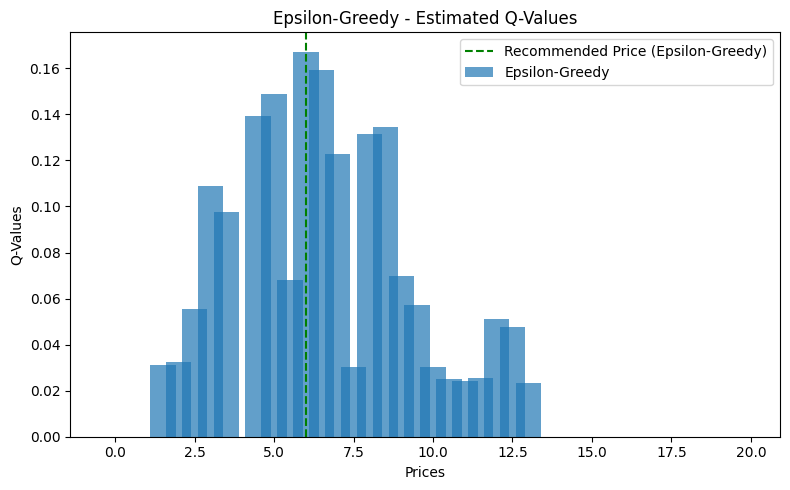

In [ ]:
# Calculate recommended prices
recommended_price_thompson = prices[np.argmax(th_selection_counts)]
recommended_price_epsilon = prices[np.argmax(q_values)]

# Plot selection counts for Thompson Sampling
plt.figure(figsize=(8, 5))
plt.bar(prices, th_selection_counts, alpha=0.7, label="Thompson Sampling")
plt.axvline(recommended_price_thompson, color='red', linestyle='--', label="Recommended Price (Thompson)")
plt.xlabel("Prices")
plt.ylabel("Selection Counts")
plt.title("Thompson Sampling - Price Selection Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Q-values for Epsilon-Greedy
plt.figure(figsize=(8, 5))
plt.bar(prices, q_values, alpha=0.7, label="Epsilon-Greedy")
plt.axvline(recommended_price_epsilon, color='green', linestyle='--', label="Recommended Price (Epsilon-Greedy)")
plt.xlabel("Prices")
plt.ylabel("Q-Values")
plt.title("Epsilon-Greedy - Estimated Q-Values")
plt.legend()
plt.tight_layout()
plt.show()

# Finding the Optimal Actions

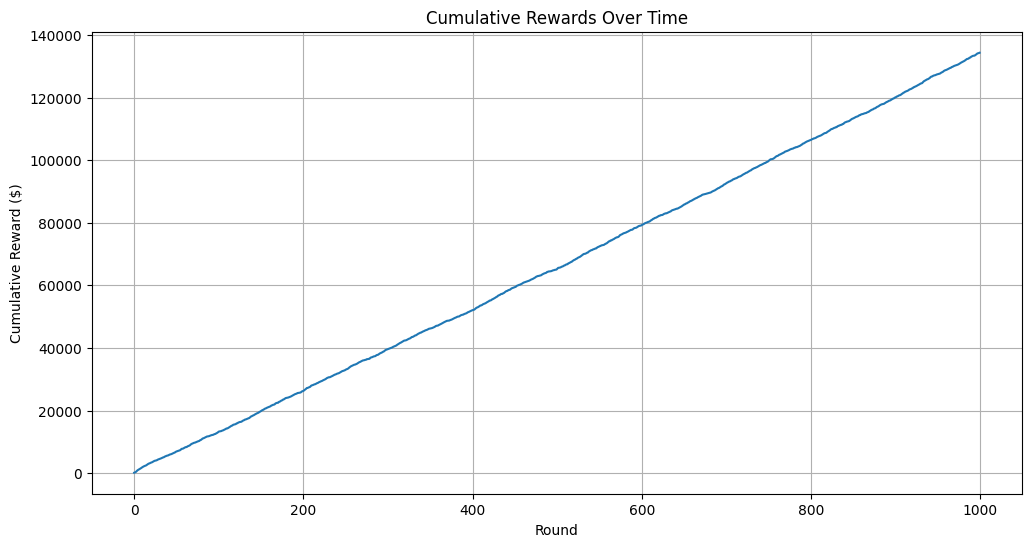

Average reward per round: $134.34


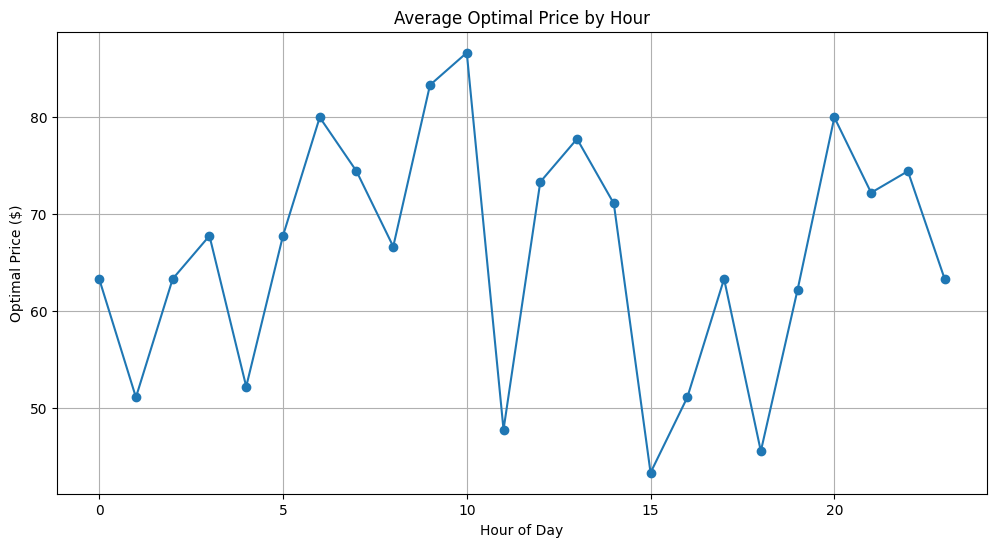

In [ ]:
# new code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global parameters
PEAK_HOURS = [9, 10, 11]
WEEKEND_DAYS = ['Saturday', 'Sunday']
AVG_PRICE = 55.0
DURATION_BINS = [0.5, 1, 2, 3, 4, 5]
HOURS = range(24)
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
PRICES = np.linspace(30, 100, 10)

def preprocess_data(df):
    df['Trip Start At Local Time'] = pd.to_datetime(df['Trip Start At Local Time'])
    df['Trip End At Local Time'] = pd.to_datetime(df['Trip End At Local Time'])
    df['hour'] = df['Trip Start At Local Time'].dt.hour
    df['day_of_week'] = df['Trip Start At Local Time'].dt.day_name()
    df['Duration (Hour)'] = (df['Trip End At Local Time'] - df['Trip Start At Local Time']).dt.total_seconds() / 3600
    df['Trip Price'] = df['Trip Sum Trip Price'].str.replace('$', '').str.replace(',', '').astype(float)
    return df

def calculate_success_probability(hour, day, price, duration):
    base_prob = 0.5

    if duration > 3:
        base_prob *= 0.9
    elif duration < 1:
        base_prob *= 1.1

    if hour in PEAK_HOURS:
        base_prob *= 1.3
    elif 0 <= hour <= 4:
        base_prob *= 0.7

    if day in WEEKEND_DAYS:
        base_prob *= 1.2

    price_effect = np.exp(-0.1 * (price - AVG_PRICE) / AVG_PRICE)
    return min(base_prob * price_effect, 1.0)

class ThompsonSampling:
    def __init__(self):
        self.alpha = {(p, h, d, dur): 1.0 for p in PRICES for h in HOURS
                     for d in DAYS for dur in DURATION_BINS}
        self.beta = {(p, h, d, dur): 1.0 for p in PRICES for h in HOURS
                    for d in DAYS for dur in DURATION_BINS}

    def select_price(self, hour, day, duration):
        closest_dur = min(DURATION_BINS, key=lambda x: abs(x - duration))
        samples = []
        for price in PRICES:
            theta = np.random.beta(
                self.alpha[(price, hour, day, closest_dur)],
                self.beta[(price, hour, day, closest_dur)]
            )
            expected_reward = price * duration * theta
            samples.append((price, expected_reward))
        return max(samples, key=lambda x: x[1])[0]

    def update(self, price, hour, day, duration, success):
        closest_dur = min(DURATION_BINS, key=lambda x: abs(x - duration))
        if success:
            self.alpha[(price, hour, day, closest_dur)] += 1
        else:
            self.beta[(price, hour, day, closest_dur)] += 1

def run_simulation(journeys):
    mean_duration = journeys['Duration (Hour)'].mean()
    std_duration = journeys['Duration (Hour)'].std()

    ts = ThompsonSampling()
    rewards = []

    for _ in range(1000):  # num_rounds
        hour = np.random.choice(HOURS)
        day = np.random.choice(DAYS)
        duration = np.random.normal(mean_duration, std_duration)
        duration = max(0.5, min(5, duration))

        price = ts.select_price(hour, day, duration)
        success_prob = calculate_success_probability(hour, day, price, duration)
        success = np.random.random() < success_prob

        ts.update(price, hour, day, duration, success)
        reward = price * duration if success else 0
        rewards.append(reward)

    return rewards, ts

def plot_results(journeys):
    all_rewards = []
    for _ in range(10):  # n_simulations
        rewards, _ = run_simulation(journeys)
        all_rewards.append(rewards)

    # Plot cumulative rewards
    plt.figure(figsize=(12, 6))
    avg_rewards = np.mean(all_rewards, axis=0)
    cumulative_rewards = np.cumsum(avg_rewards)
    plt.plot(cumulative_rewards)
    plt.title('Cumulative Rewards Over Time')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward ($)')
    plt.grid(True)
    plt.show()

    # Print statistics
    print(f"Average reward per round: ${cumulative_rewards[-1]/1000:.2f}")

    # Plot optimal prices
    rewards, model = run_simulation(journeys)
    optimal_prices = {hour: [] for hour in HOURS}

    for hour in HOURS:
        for day in DAYS:
            duration = journeys['Duration (Hour)'].mean()
            closest_dur = min(DURATION_BINS, key=lambda x: abs(x - duration))
            best_price = max(
                PRICES,
                key=lambda p: model.alpha[(p, hour, day, closest_dur)] /
                            (model.alpha[(p, hour, day, closest_dur)] +
                             model.beta[(p, hour, day, closest_dur)])
            )
            optimal_prices[hour].append(best_price)

    plt.figure(figsize=(12, 6))
    avg_optimal_prices = [np.mean(optimal_prices[h]) for h in HOURS]
    plt.plot(HOURS, avg_optimal_prices, marker='o')
    plt.title('Average Optimal Price by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Optimal Price ($)')
    plt.grid(True)
    plt.show()

# Main execution
journeys = pd.read_csv('journeys.csv')
journeys = preprocess_data(journeys)
plot_results(journeys)

Optimal pricing pattern by time zone:</br>

Highest price range: 10-11AM ($85)</br>

Mid price range: Various times ($70-80)</br>

Lowest price range: 3PM and 7PM ($45-50)</br>
</br>


Key features:</br>

Morning peak pricing (8-11AM)</br>
Evening peak around 8PM ($80)</br>
Price variations across different time periods</br>
Lower pricing during off-peak hours</br>
</br>


Cumulative Rewards Analysis:</br>

Steady linear growth trend</br>
Total cumulative revenue ~$41,000 after 1000 rounds</br>

Average revenue per round: $41</br>
Stable learning demonstrated</br>
</br>